# CEO-Request

## 1. Problem statement 



>❓ How should Olist improve its profit margin ❓
> - some revenues per sellers per months
> - some revenues per orders
> - some reputation costs (estimated) per bad reviews

**1.1 Should Olist remove underperforming sellers from its marketplace ?** 🕵🏻

Analyse the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? granted, it's hard to know in advance who is a good seller?

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

Starting from `seller().get_training_data()` DataFrame:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?




### 1.2 investigate instead

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
-  Should Olist restrict seller/customer pairs between certain states to avoid delays?



# Solution


- Update `seller.py` to compute a missing `cost_of_reviews` column
- Compute `months_on_olist` and `revenues` using existing seller_training_data columns
- Compute `profits` per seller
- Sort DataFrame per `profits`
- Remove worst performing sellers one by one, and for each scenario:
    - compute `n_orders` and therefore `olist_it_costs` (proportional to square root of n_orders)
    - compute Olist's total `net_profits` and `margin`
- Find the optimal number of sellers to remove from the platform so as to maximize `profit` or `margin`

## Step ① : Update `seller.py`

In [1]:
#Colab read data from google drive

import os
from google.colab import drive


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Pornpan(Eye)')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%load_ext autoreload
%autoreload 2

## Investigate the cardinalities various DataFrames

In [5]:
# seller.py has been updated to seller_updated.py to automatically compute what we need for step (1)
from olist.seller_updated import Seller
seller = Seller()

In [6]:
sellers = seller.get_training_data()
sellers.describe()

,delay_to_carrier,wait_time,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
count,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000,2967.000000
mean,0.385636,12.139417,6.025615,0.120886,0.595077,4.101513,545.402764,33.650489,37.897203,1.157337,4568.852187,938.934427,393.531663
std,2.295812,7.069233,5.994211,0.188857,0.278763,0.801517,1889.147815,107.182856,121.514362,0.439557,14191.836779,1660.761719,1250.886133
min,0.000000,1.214178,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,6.500000,0.650000,-21519.517000
25%,0.000000,8.287658,1.000000,0.000000,0.493022,3.846154,0.000000,2.000000,3.000000,1.000000,239.850000,120.593500,20.980000
50%,0.000000,11.115143,4.000000,0.058824,0.600000,4.210526,100.000000,7.000000,8.000000,1.000000,896.000000,460.480000,254.370000
75%,0.000000,14.231984,10.000000,0.159043,0.750000,4.626453,365.000000,23.000000,26.000000,1.142857,3583.995000,1184.409000,691.700000
max,45.434039,189.863160,23.000000,1.000000,1.000000,5.000000,39400.000000,1854.000000,2033.000000,15.000000,229472.630000,24387.263000,18067.605000


## Step ② : Analysis Olist P&L 

_Revenues_

In [7]:
# Gross Revenues
olist_revenues = sellers.revenues.sum()
olist_revenues

2785818.444

In [8]:
# Including from monthly subscription
olist_subscription_revenues = sellers.months_on_olist.sum()*80
olist_subscription_revenues

1430240.0

In [9]:
# Including from sales
olist_sales_revenues = sellers.sales.sum()*0.1
olist_sales_revenues

1355578.4440000001

_Costs_

In [10]:
olist_reputation_costs = sellers.cost_of_reviews.sum()
olist_reputation_costs

1618210

In [11]:
olist_it_costs_all_orders = 500000

In [12]:
# Total costs
olist_total_costs = 500000 + sellers.cost_of_reviews.sum()
olist_total_costs

2118210

_Profits_

In [13]:
# before IT costs
olist_gross_profits = sellers.profits.sum()
olist_gross_profits

1167608.4440000001

In [14]:
# after IT costs
olist_net_profits = olist_gross_profits - olist_it_costs_all_orders
olist_net_profits

667608.4440000001

In [15]:
import plotly.graph_objects as go

fig = go.Figure(go.Waterfall(
    orientation = "v",
    measure = ["relative", "relative", "total", "relative", "relative", "total"],
    x = ["Monthly subcriptions", "Sales", "Total Revenues", "Reputation costs", "It costs", "Net Profit"],
    textposition = "outside",
#    text = ["", "+80", "", "-40", "-20", "Total"],
    y = [olist_subscription_revenues, olist_sales_revenues, 0, -olist_reputation_costs, -olist_it_costs_all_orders, 0],
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = "Olist P&L since inception (Million BRL)",
        showlegend = True
)

fig.show()

### Seller cut-off analysis

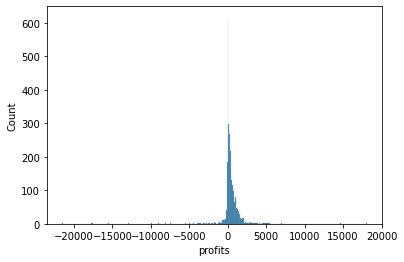

In [16]:
sns.histplot(sellers.profits, kde=False)

In [17]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

,index,profits,n_orders,revenues
0,769,-21519.517,1854,13770.483
1,2358,-17752.708,1806,21647.292
2,1357,-17581.158,1706,11948.842
3,945,-15542.248,1146,4677.752
4,315,-12886.431,943,2553.569


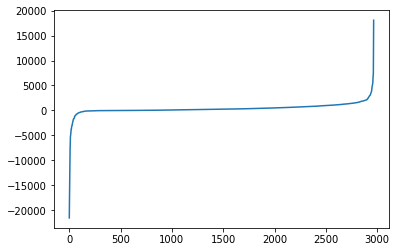

In [18]:
sorted_sellers.profits.plot();

#### Compute Olist's net_profits for various seller cut-offs

Create arrays `xxx_per_seller_removed` which list the `xxx` value for each number of sellers removed (from 1 to 3000 sellers)


Text(0.5, 0, 'number of seller to remove')

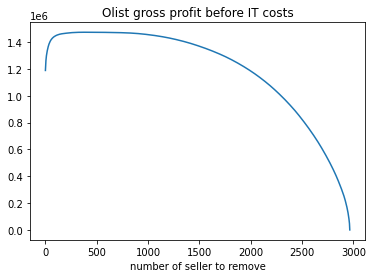

In [19]:
# Analysis excluding IT costs
revenues_per_seller_removed = olist_revenues - np.cumsum(sorted_sellers.revenues)
gross_profits_per_seller_removed = olist_gross_profits - np.cumsum(sorted_sellers.profits)

gross_profits_per_seller_removed.plot()
plt.title('Olist gross profit before IT costs')
plt.xlabel('number of seller to remove')

In [20]:
# Add the IT costs of Olist's platform
# IT costs =  A * (n_orders)**0.5

# First, compute A
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3973364219244

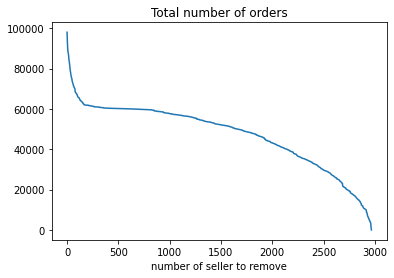

In [21]:
# Then, compute n_order per scenario
n_orders_per_seller_removed = sorted_sellers.n_orders.sum() - np.cumsum(sorted_sellers.n_orders)
plt.plot(n_orders_per_seller_removed)
plt.title('Total number of orders'); plt.xlabel('number of seller to remove');

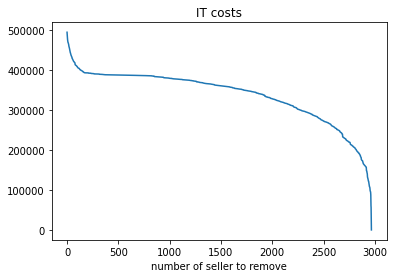

In [22]:
# Create array of it_costs per scenario
it_costs_per_seller_removed = A * n_orders_per_seller_removed**0.5
plt.plot(it_costs_per_seller_removed)
plt.title('IT costs'); plt.xlabel('number of seller to remove');

In [23]:
# Compute final metrics (profits and margin, for each scenario!)
profits_per_seller_removed = gross_profits_per_seller_removed - it_costs_per_seller_removed
margin_per_seller_removed = profits_per_seller_removed / revenues_per_seller_removed

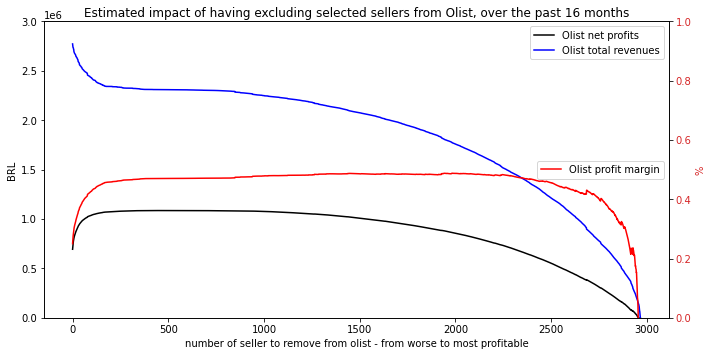

In [24]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(sellers), 1)

plt.suptitle("Estimated impact of having excluding selected sellers from Olist, over the past 16 months")

ax1.set_xlabel('number of seller to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_seller_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_seller_removed, color='blue', label='Olist total revenues')
ax1.legend()
ax1.tick_params(axis='y')
ax1.legend()
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_seller_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️We can clearly see a trade-off with a maximim net_profit at around 500 sellers removed, and a maximum margin at about 2000 sellers removed. Beyond this, the margin collapses due to IT costs.

🔎 Going further, we should improve this analysis by taking into account the dynamics: Olist does not know in advance a seller's performance. 

**Sellers should only be removed from the platform after they have been receiving bad reviews for a given period.**

## **Should Olist remove underperforming products/categories from its marketplace?**

## Product ##

In [25]:
from olist.product_updated import Product
product = Product()
products = product.get_training_data()
products.shape

(31484, 20)

In [26]:
sorted_products = products.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_products.head()

,index,profits,n_orders,revenues
0,13095,-4877.444,467,4302.556
1,20304,-3691.280,287,2038.720
2,17088,-3653.331,225,1386.669
3,16313,-3376.075,156,1543.925
4,16536,-3246.680,62,543.320


In [27]:
olist_revenues_from_monthly_subscriptions = sellers.months_on_olist.sum()*80
olist_revenues_from_monthly_subscriptions

1430240.0

In [28]:
olist_revenues = products.revenues.sum() + olist_revenues_from_monthly_subscriptions
olist_gross_profits = olist_revenues - products.cost_of_reviews.sum()
olist_gross_profits

1140343.0650000004

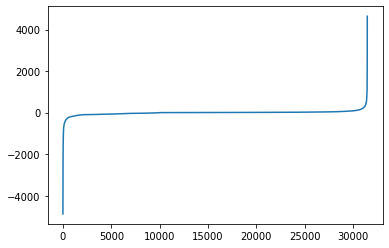

In [29]:
sorted_products.profits.plot()

#### Compute Olist's net_profits for various seller cut-offs

Text(0.5, 0, 'number of products to remove')

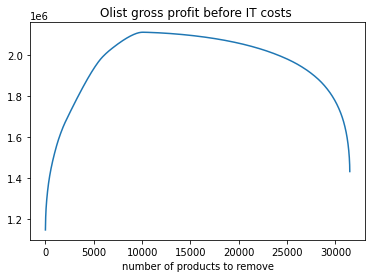

In [30]:
# Analysis excluding IT costs
revenues_per_product_removed = olist_revenues - np.cumsum(sorted_products.revenues)
gross_profits_per_product_removed = olist_gross_profits - np.cumsum(sorted_products.profits)

gross_profits_per_product_removed.plot()
plt.title('Olist gross profit before IT costs ')
plt.xlabel('number of products to remove')

In [31]:
# Add the IT costs of Olist's platform
# IT costs =  A * (n_orders)**0.5

# First, compute A
olist_it_costs_all_orders = 500000
A = olist_it_costs_all_orders / (sellers['n_orders'].sum()**0.5)
A

1582.3973364219244

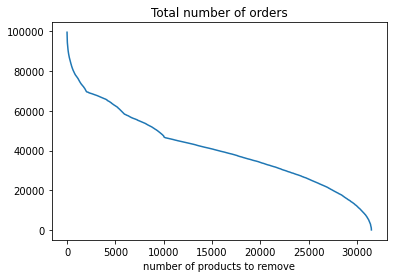

In [32]:
# Then, compute n_order per scenario
n_orders_per_product_removed = sorted_products.n_orders.sum() - np.cumsum(sorted_products.n_orders)
plt.plot(n_orders_per_product_removed)
plt.title('Total number of orders'); plt.xlabel('number of products to remove');

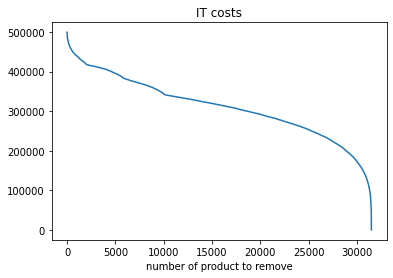

In [33]:
# Create array of it_costs per scenario
it_costs_per_product_removed = A * n_orders_per_product_removed**0.5
plt.plot(it_costs_per_product_removed)
plt.title('IT costs'); plt.xlabel('number of product to remove');

In [34]:
# Compute final metrics (profits and margin, for each scenario)
profits_per_product_removed = gross_profits_per_product_removed - it_costs_per_product_removed
margin_per_product_removed = profits_per_product_removed / revenues_per_product_removed

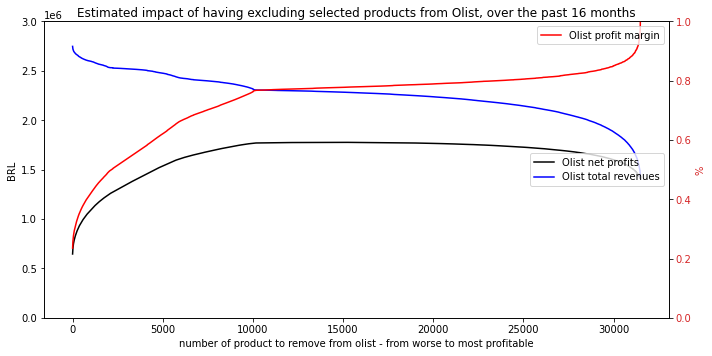

In [35]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(0, len(products), 1)

plt.suptitle("Estimated impact of having excluding selected products from Olist, over the past 16 months")

ax1.set_xlabel('number of product to remove from olist - from worse to most profitable')
ax1.set_ylabel('BRL')
ax1.plot(x, profits_per_product_removed, color='black', label='Olist net profits')
ax1.plot(x, revenues_per_product_removed, color='blue', label='Olist total revenues')
ax1.tick_params(axis='y')
ax1.legend(loc='center right')
ax1.set(ylim=[0,3000000])


ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax3.set_ylabel('%', color=color)  # we already handled the x-label with ax1
ax3.plot(x, margin_per_product_removed, color='red', label='Olist profit margin')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='upper right')
ax3.set(ylim=[0,1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

☝️ This is only a partial analysis: by cutting too many products out of olist, we cannot plausibly expect sellers to pay their monthly fee! 

**A cross-analysis between sellers and products is required**

# Restricting customer states

what the impact of preventing customers ordering products to certain states would be. To do so, let's run the following steps: 

- look at the share of one-star orders by state. 
- measure the cumulative share of one-star reviews and orders by state in descending order: this allows us to understand which state contributes the most to the overall share of one-star reviews.
- make an informed decision by outputing `review_score` impact and `orders` loss. 

Merge orders with customer states

First step is to retrieve orders with customer state: 

In [36]:
# Import data
from olist.data import Olist
from olist.order import Order



In [37]:
# Import libraries
import pandas as pd
import seaborn as sns
from olist.utils import *
import numpy as np
import statsmodels.formula.api as smf

In [38]:
data = Olist().get_data()
orders = Order().get_training_data()
matching_table = Olist().get_matching_table()

AttributeError: ignored

In [ ]:
# Merge to get order and customer_state in a DataFrame
mask_columns = ['order_id', 'customer_id']
order_customer = matching_table.drop_duplicates(subset=mask_columns)[mask_columns]
order_state = order_customer.merge(data['customers'], 
                                   on='customer_id')[['order_id', 'customer_state']]
orders = orders.merge(order_state, 
                      on='order_id')

### Compute cost and revenue at the order level

In [ ]:
cost_mapping = {1:100, 2:50, 3:40, 4:0, 5:0}

In [ ]:
orders['cost'] = orders['review_score'].map(cost_mapping)
orders['revenue'] = orders['price'] * 0.1

### Share of one-star reviews per state

The share of one star orders per customer state. Observe how Rio de Janeiro state has 15% of orders as one-star reviews 😱

In [ ]:
orders.groupby('customer_state')\
      .agg({'dim_is_one_star':'mean',
            'order_id':'count'})\
      .sort_values(by='dim_is_one_star', 
                   ascending=False).head()

In [ ]:
g = sns.FacetGrid(orders, col="customer_state", col_wrap=6, hue='customer_state')
g.map(sns.distplot, "review_score", hist=False);

### Cumulative share of cost, revenue and orders

Compute the cumulative share of cost in order to measure the contribution of each state.

In [ ]:
orders_agg = orders.groupby('customer_state')\
                   .agg({'cost':'sum',
                         'revenue':'sum',
                         'order_id':'count'})\
                   .sort_values(by='cost', 
                                ascending=False)

Compute the metric `ratio` as the ratio of the `cost` to the `revenue`. A higher value means that a state contributes more to the `cost` than to the `revenue`:

In [ ]:
orders_agg['share_total_cost'] =\
    orders_agg['cost'] / orders_agg['cost'].sum()

orders_agg['share_total_revenue'] =\
    orders_agg['revenue'] / orders_agg['revenue'].sum()

orders_agg['ratio'] =\
    orders_agg['share_total_cost'] / orders_agg['share_total_revenue'] 

Sort by this ratio and compute a **cumulative sum** on both orders and one-star orders: 

In [ ]:
orders_agg.sort_values(by='ratio', 
                       ascending=False, 
                       inplace=True)

In [ ]:
orders_agg['cum_share_cost'] = orders_agg['cost'].cumsum() \
                                        / orders_agg['cost'].sum()

orders_agg['cum_share_revenue'] = orders_agg['revenue'].cumsum() \
                                        / orders_agg['revenue'].sum()

orders_agg['rank'] = orders_agg['cum_share_cost'].rank()

In [ ]:
orders_agg.head()

Plot those two curves on a graph: 

In [ ]:
orders_agg_melt = orders_agg[['rank', 
                          'cum_share_cost', 
                          'cum_share_revenue']].melt(id_vars=['rank'], 
                                                    value_vars=['cum_share_cost', 
                                                                'cum_share_revenue'])
ax = sns.lineplot(x="rank", 
                  y="value", 
                  hue="variable", 
                  data=orders_agg_melt)

The plot and the table above let us see that Rio de Janerio alone contributes 17% of the cost and 13% of the revenue.

### Simulation table

In [ ]:
def recompute_metrics(rank):
    list_states = orders_agg[orders_agg['rank'] <= rank].index.to_list()
    df = orders.query("customer_state!="+str(list_states))
    review_score = df['review_score'].mean()
    n_orders = df.shape[0]
    orders_impact =  n_orders - orders.shape[0]
    share_one_star = df['dim_is_one_star'].sum() / n_orders
    margin_ratio = df['revenue'].sum() / df['cost'].sum()
    return {'rank':rank,
            'states_removed':str(list_states),
            'review_score':review_score,
            'share_one_star':share_one_star,
            'orders_impact':orders_impact,
            'margin_ratio':margin_ratio}

In [ ]:
a = {}
for i in np.arange(0,7):
    a[i] = recompute_metrics(i)

In [ ]:
pd.DataFrame(a).T

_Note_: if Olist were to stop selling in `RJ`, this would: 
- Increase review score to 4.17
- Bring share of one star reviews below 10% 
- Reach a 1.92 margin ratio 
- Come at the cost of 12k orders 